[*********************100%***********************]  20 of 20 completed
C:\Users\iparra\AppData\Local\Temp\ipykernel_14848\3939436210.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\iparra\AppData\Local\Temp\ipykernel_14848\3939436210.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


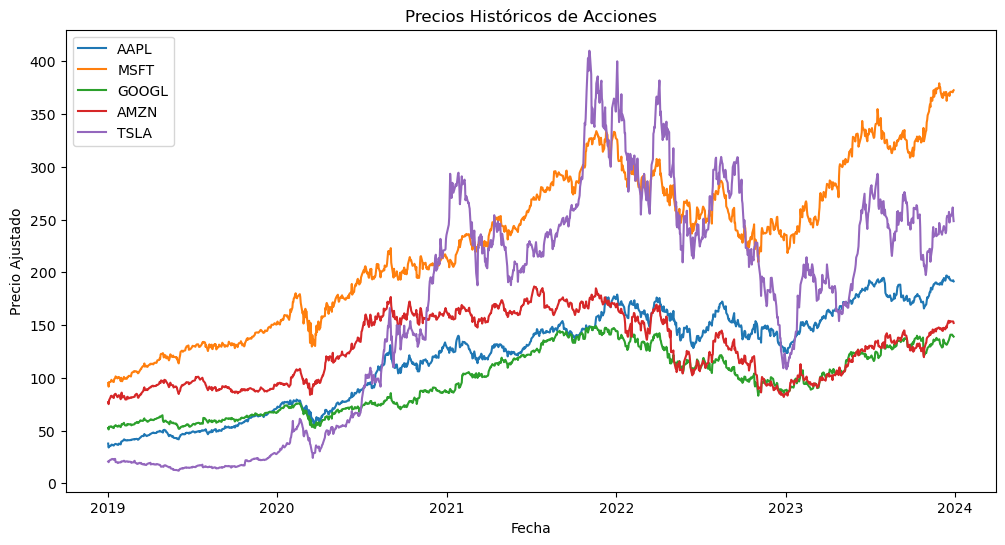

Datos descargados y preprocesados correctamente.


In [1]:
# Notebook 1: Obtención y Preparación de Datos

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de 20 acciones variadas
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "JPM", "BAC", "GS", "V", "MA", "PEP", "KO", "PG", "JNJ", "MRNA", "NFLX", "DIS", "IBM"]

# Definir período de análisis (5 años)
start_date = "2019-01-01"
end_date = "2024-01-01"

# Descargar datos de precios ajustados
# data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Adj Close"]
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"]


# Manejo de valores faltantes (forward-fill y backward-fill)
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Guardar datos procesados
data.to_csv("acciones_preprocesadas.csv")

# Visualización de precios de algunas acciones
plt.figure(figsize=(12,6))
for ticker in tickers[:5]:  # Graficar solo 5 acciones como ejemplo
    plt.plot(data.index, data[ticker], label=ticker)
plt.legend()
plt.title("Precios Históricos de Acciones")
plt.xlabel("Fecha")
plt.ylabel("Precio Ajustado")
plt.show()

print("Datos descargados y preprocesados correctamente.")



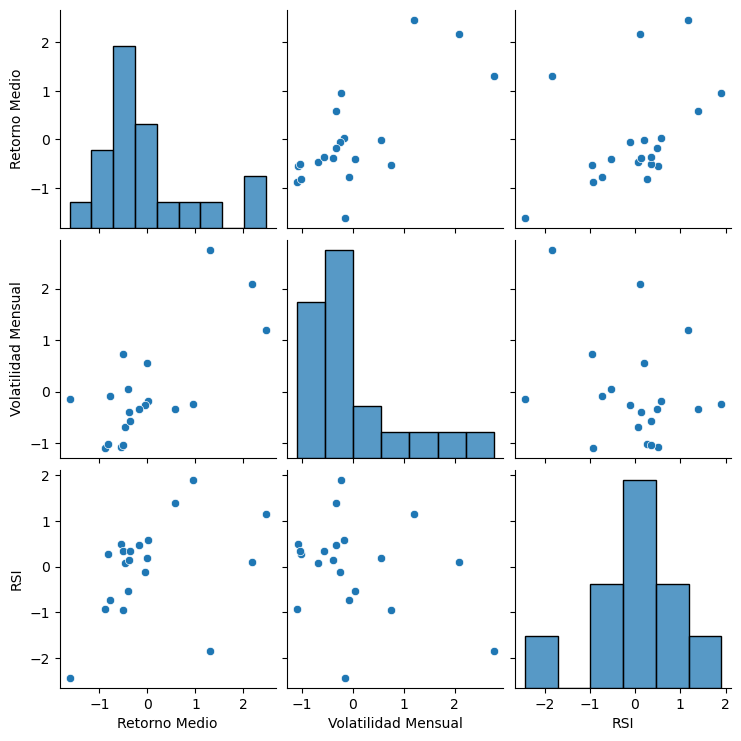

Feature Engineering completado y guardado.


In [2]:
# Notebook 2: Feature Engineering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos de precios procesados
data = pd.read_csv("acciones_preprocesadas.csv", index_col=0, parse_dates=True)

# Cálculo de retornos logarítmicos diarios
returns = np.log(data / data.shift(1))

# Volatilidad (desviación estándar de los retornos) a nivel semanal y mensual
volatility_weekly = returns.rolling(5).std()
volatility_monthly = returns.rolling(21).std()

# RSI (Relative Strength Index) - 14 días
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(period).mean()
    loss = -delta.where(delta < 0, 0).rolling(period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_14 = data.apply(calculate_rsi)

# Máximos y mínimos históricos en los últimos 5 años
rolling_max = data.rolling(window=252).max()
rolling_min = data.rolling(window=252).min()

# Normalización de datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(pd.concat([returns.mean(), volatility_monthly.mean(), rsi_14.mean()], axis=1)),
                        columns=['Retorno Medio', 'Volatilidad Mensual', 'RSI'],
                        index=data.columns)

# Guardar features procesadas
features.to_csv("features_acciones.csv")

# Visualización de distribución de features
sns.pairplot(features)
plt.show()

print("Feature Engineering completado y guardado.")

Resumen estadístico de las características:
       Retorno Medio  Volatilidad Mensual           RSI
count   2.000000e+01         2.000000e+01  2.000000e+01
mean    5.828671e-17         2.609024e-16 -1.387779e-17
std     1.025978e+00         1.025978e+00  1.025978e+00
min    -1.620550e+00        -1.088077e+00 -2.431226e+00
25%    -5.230598e-01        -5.997789e-01 -5.754739e-01
50%    -3.745771e-01        -2.382894e-01  1.654296e-01
75%     1.603167e-01         1.745814e-01  4.912652e-01
max     2.468310e+00         2.757197e+00  1.906128e+00


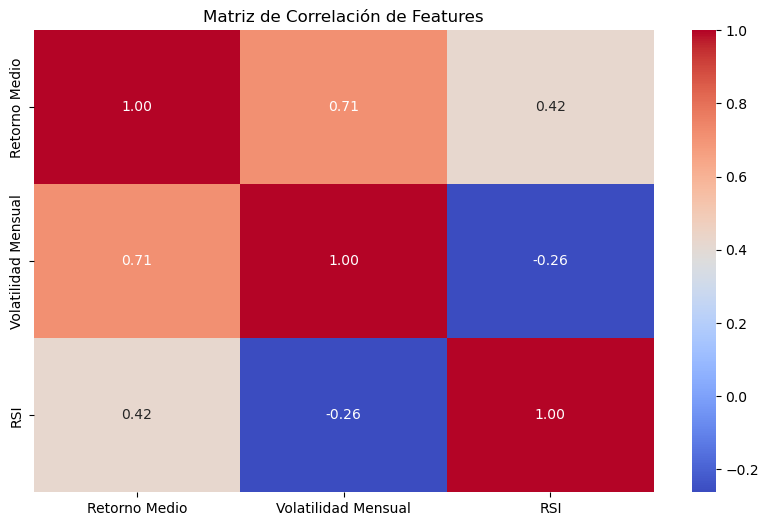

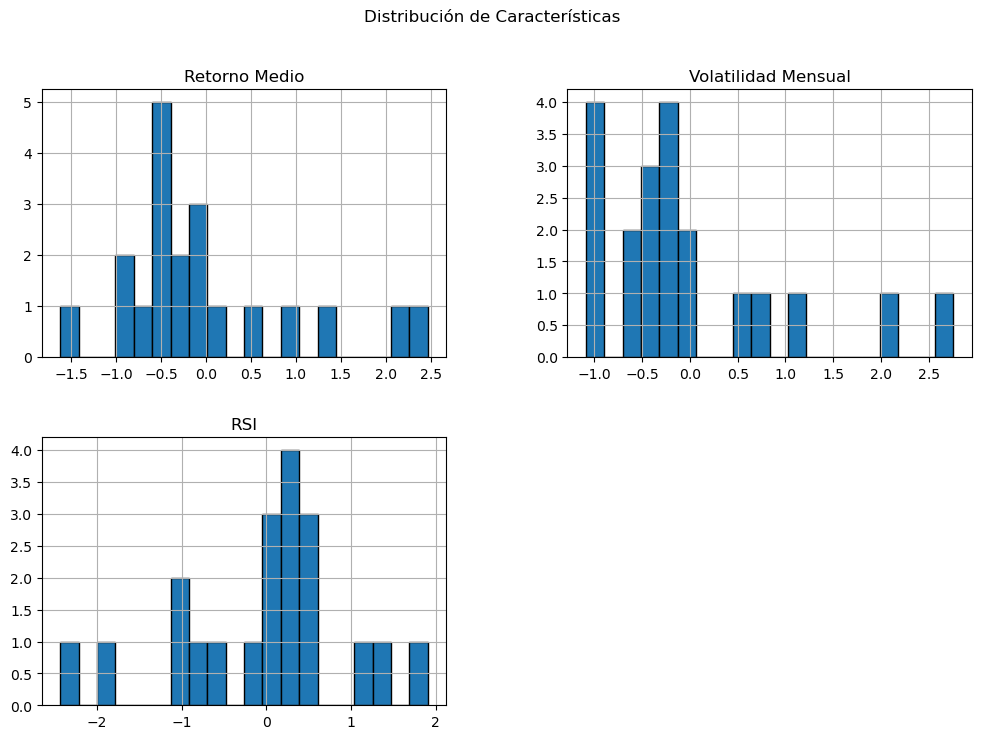

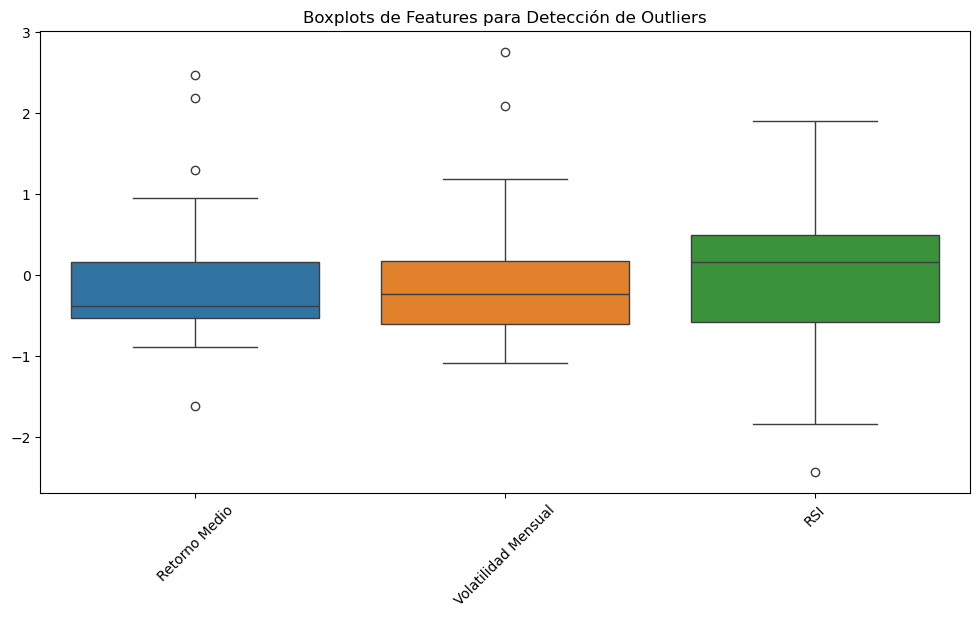

Outliers en Retorno Medio:
      Retorno Medio  Volatilidad Mensual       RSI
DIS       -1.620550            -0.148410 -2.431226
MRNA       1.302124             2.757197 -1.839463
NVDA       2.468310             1.191710  1.161177
TSLA       2.184455             2.088892  0.114041
Outliers en Volatilidad Mensual:
      Retorno Medio  Volatilidad Mensual       RSI
MRNA       1.302124             2.757197 -1.839463
TSLA       2.184455             2.088892  0.114041
Outliers en RSI:
     Retorno Medio  Volatilidad Mensual       RSI
DIS       -1.62055             -0.14841 -2.431226
Análisis Exploratorio de Datos (EDA) completado.


In [3]:
# Notebook 3: Análisis Exploratorio de Datos (EDA)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos de features procesadas
features = pd.read_csv("features_acciones.csv", index_col=0)

# Estadísticas descriptivas
print("Resumen estadístico de las características:")
print(features.describe())

# Matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación de Features")
plt.show()

# Histogramas de distribución de cada feature
features.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Distribución de Características")
plt.show()

# Boxplots para detectar outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=features)
plt.title("Boxplots de Features para Detección de Outliers")
plt.xticks(rotation=45)
plt.show()

# Análisis de outliers: mostrar valores extremos
for col in features.columns:
    q1 = features[col].quantile(0.25)
    q3 = features[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = features[(features[col] < lower_bound) | (features[col] > upper_bound)]
    print(f"Outliers en {col}:")
    print(outliers)

print("Análisis Exploratorio de Datos (EDA) completado.")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

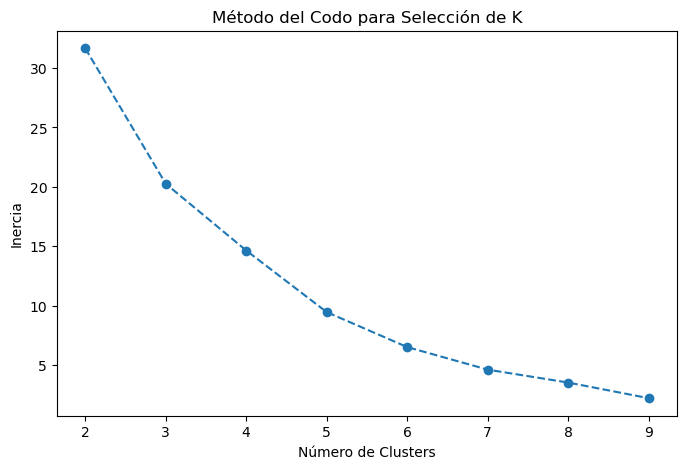

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

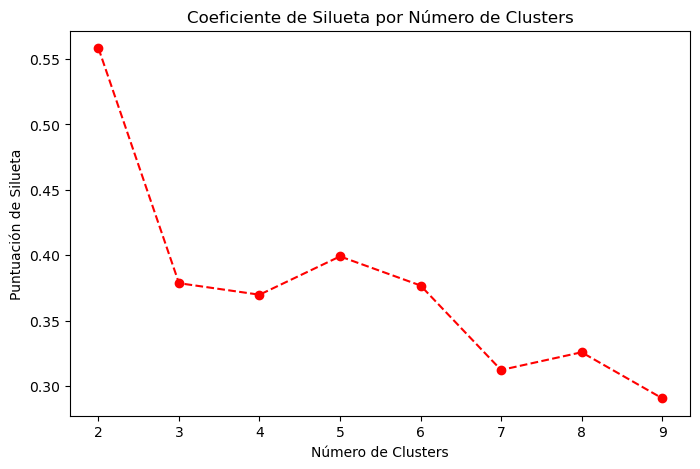

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


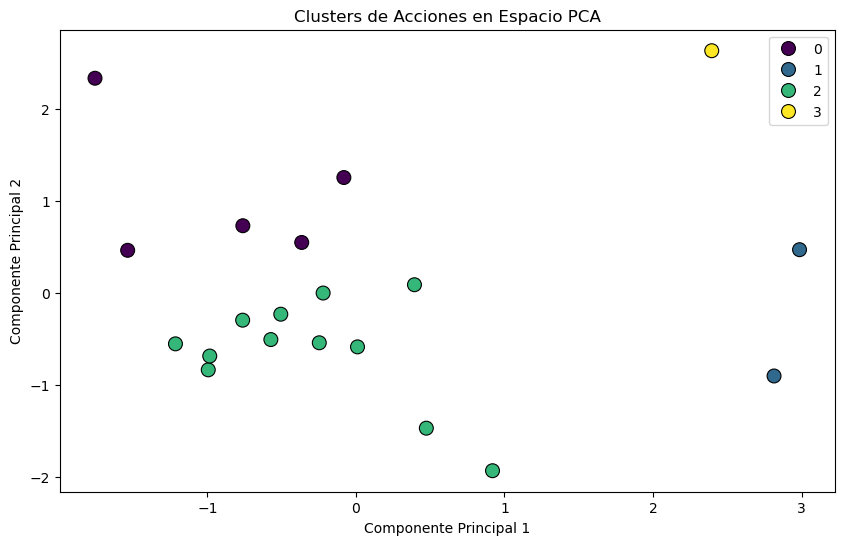

Clustering completado y guardado.


In [4]:
# Notebook 4: Clustering de Acciones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Cargar las features procesadas
features = pd.read_csv("features_acciones.csv", index_col=0)

# Determinar número óptimo de clusters con el método del codo
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo para Selección de K")
plt.show()

# Determinar número óptimo de clusters con el coeficiente de silueta
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    silhouette_scores.append(silhouette_score(features, labels))

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Número de Clusters")
plt.ylabel("Puntuación de Silueta")
plt.title("Coeficiente de Silueta por Número de Clusters")
plt.show()

# Aplicar K-Means con el número óptimo de clusters (suponiendo K=4 basado en los gráficos)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
features['Cluster'] = kmeans.fit_predict(features)

# Visualización de clusters con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features.drop(columns=['Cluster']))
features['PCA1'] = pca_result[:, 0]
features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=features, palette='viridis', s=100, edgecolor='black')
plt.title("Clusters de Acciones en Espacio PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

# Guardar los resultados de clustering
features.to_csv("features_clusters.csv")

print("Clustering completado y guardado.")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

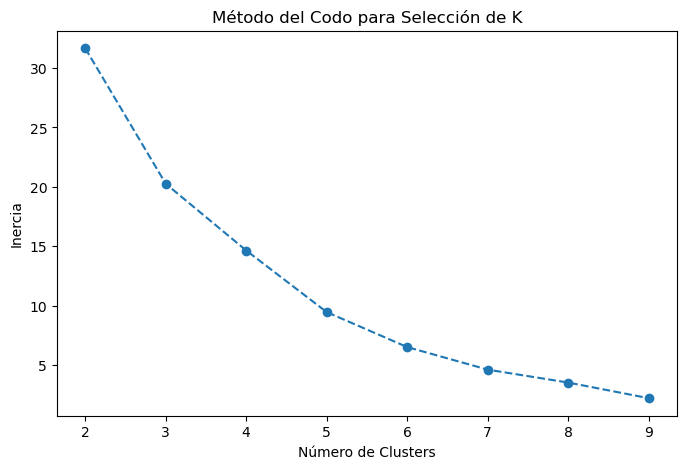

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

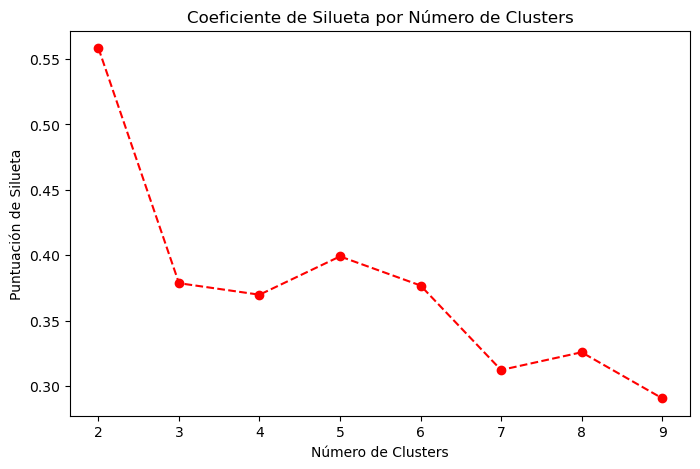

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


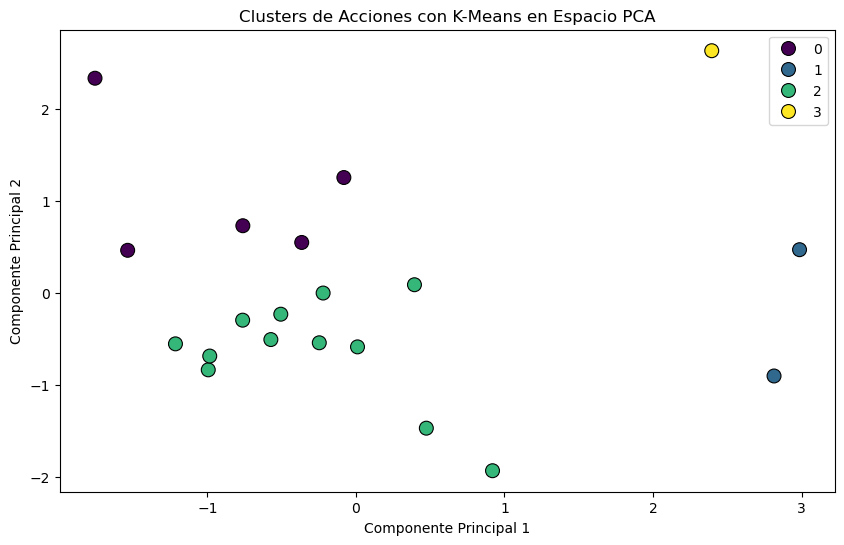

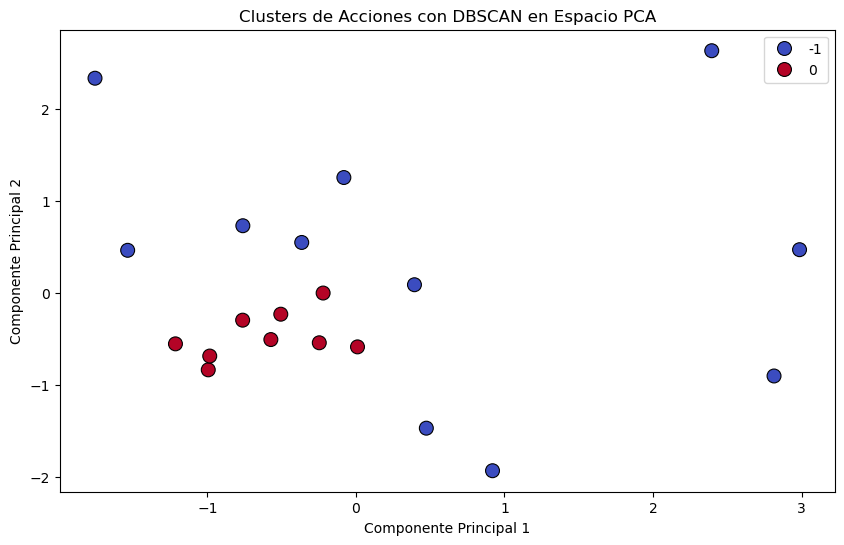

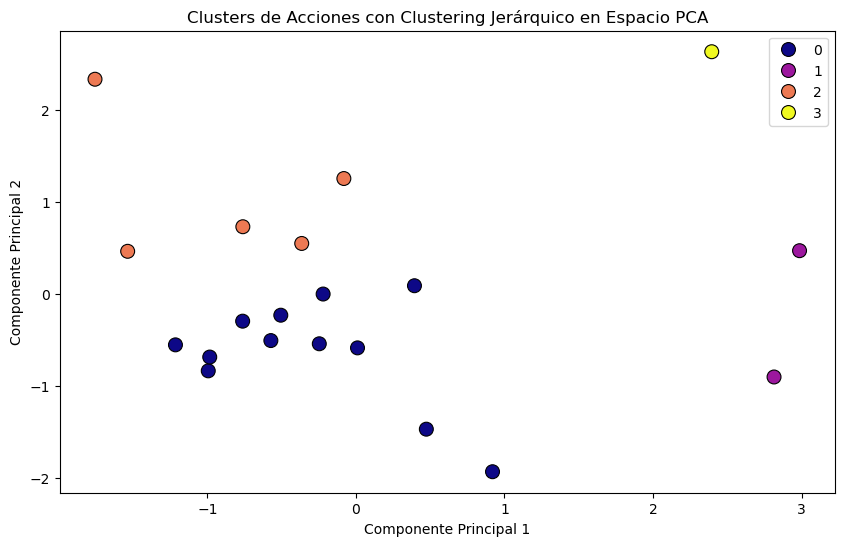

Clustering con K-Means, DBSCAN y Jerárquico completado y guardado.


In [5]:
# Notebook 4: Clustering de Acciones (K-Means, DBSCAN y Jerárquico)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Cargar las features procesadas
features = pd.read_csv("features_acciones.csv", index_col=0)

# Determinar número óptimo de clusters con el método del codo
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.title("Método del Codo para Selección de K")
plt.show()

# Determinar número óptimo de clusters con el coeficiente de silueta
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    silhouette_scores.append(silhouette_score(features, labels))

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='r')
plt.xlabel("Número de Clusters")
plt.ylabel("Puntuación de Silueta")
plt.title("Coeficiente de Silueta por Número de Clusters")
plt.show()

# Aplicar K-Means con el número óptimo de clusters (suponiendo K=4 basado en los gráficos)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
features['Cluster_KMeans'] = kmeans.fit_predict(features)

# Aplicar DBSCAN para clustering basado en densidad
dbscan = DBSCAN(eps=0.5, min_samples=3)  # Ajustar eps según los datos
features['Cluster_DBSCAN'] = dbscan.fit_predict(features)

# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=4)
features['Cluster_Hierarchical'] = hierarchical.fit_predict(features)

# Visualización de clusters con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features.drop(columns=['Cluster_KMeans', 'Cluster_DBSCAN', 'Cluster_Hierarchical']))
features['PCA1'] = pca_result[:, 0]
features['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_KMeans', data=features, palette='viridis', s=100, edgecolor='black')
plt.title("Clusters de Acciones con K-Means en Espacio PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_DBSCAN', data=features, palette='coolwarm', s=100, edgecolor='black')
plt.title("Clusters de Acciones con DBSCAN en Espacio PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_Hierarchical', data=features, palette='plasma', s=100, edgecolor='black')
plt.title("Clusters de Acciones con Clustering Jerárquico en Espacio PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

# Guardar los resultados de clustering
features.to_csv("features_clusters_comparacion.csv")

print("Clustering con K-Means, DBSCAN y Jerárquico completado y guardado.")


In [6]:
!pip install pyportfolioopt

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/62.7 kB ? eta -:--:--
   ---------------------------------------  61.4/62.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 62.7/62.7 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.1/1.1 MB 4.3 MB/s eta 0:00:01
   ------------------- -------------------- 0.5/1.1 MB 6.6 MB/s eta 0:00:01
   -------------------------------------- - 1.0/1.1 MB 8.3 MB/s eta 0:00:01
   -------------------------------------- - 1.0/1.1 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/72.2 kB ? eta -:--:--
   ---------------------------------------- 72.2/72.2 kB 3.9 MB/s eta 0:00:00
   --------------------

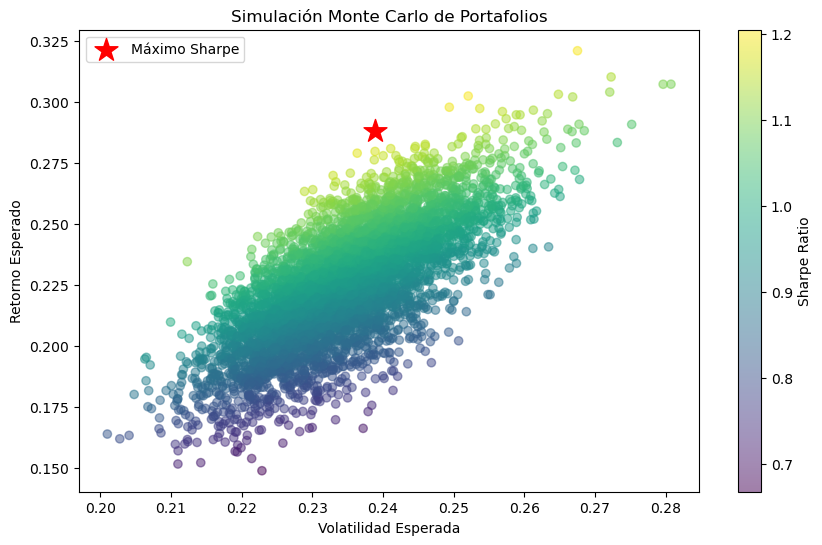

Optimización de cartera completada y guardada.


In [7]:
# Notebook 5: Optimización de Cartera con Monte Carlo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

# Cargar datos de clustering y precios históricos
data = pd.read_csv("acciones_preprocesadas.csv", index_col=0, parse_dates=True)
features = pd.read_csv("features_clusters.csv", index_col=0)

# Cálculo de retornos diarios
returns = np.log(data / data.shift(1)).dropna()

# Cálculo de estadísticas para la optimización
mu = expected_returns.mean_historical_return(data)  # Retornos esperados
S = risk_models.sample_cov(data)  # Matriz de covarianza

# Simulación Monte Carlo de 5000 combinaciones
num_portfolios = 5000
results = np.zeros((4, num_portfolios))
weights_list = []
np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(data.columns))
    weights /= np.sum(weights)
    
    port_return = np.dot(weights, mu)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
    sharpe_ratio = port_return / port_volatility
    
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio
    results[3, i] = i
    weights_list.append(weights)

# Encontrar el portafolio con mejor Sharpe Ratio
max_sharpe_idx = results[2].argmax()
best_weights = weights_list[max_sharpe_idx]

# Visualización de la frontera eficiente
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], marker='*', color='red', s=300, label='Máximo Sharpe')
plt.xlabel('Volatilidad Esperada')
plt.ylabel('Retorno Esperado')
plt.title('Simulación Monte Carlo de Portafolios')
plt.legend()
plt.show()

# Guardar la mejor asignación de pesos en el portafolio óptimo
optimal_portfolio = pd.DataFrame({"Ticker": data.columns, "Peso Óptimo": best_weights})
optimal_portfolio.to_csv("portafolio_optimo.csv", index=False)

print("Optimización de cartera completada y guardada.")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

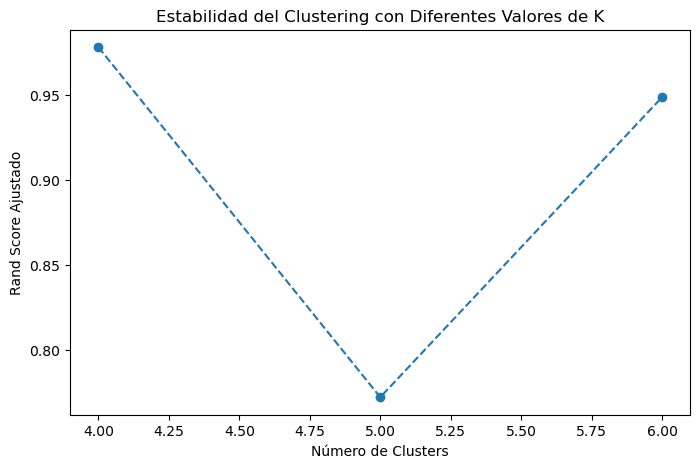

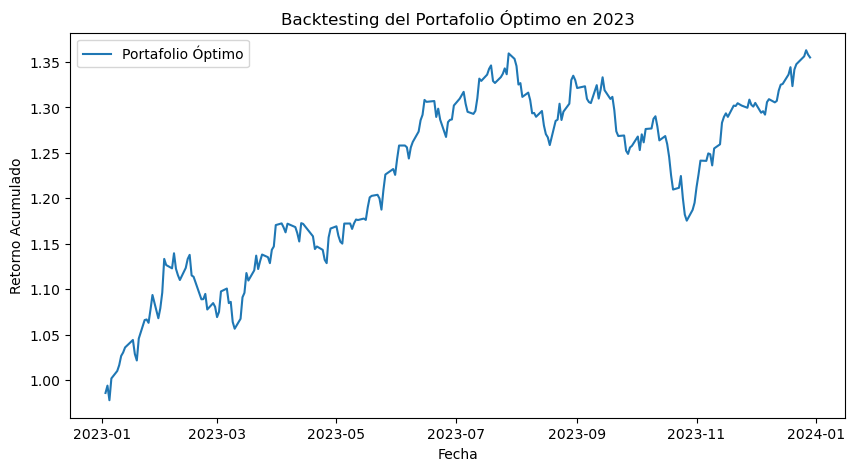

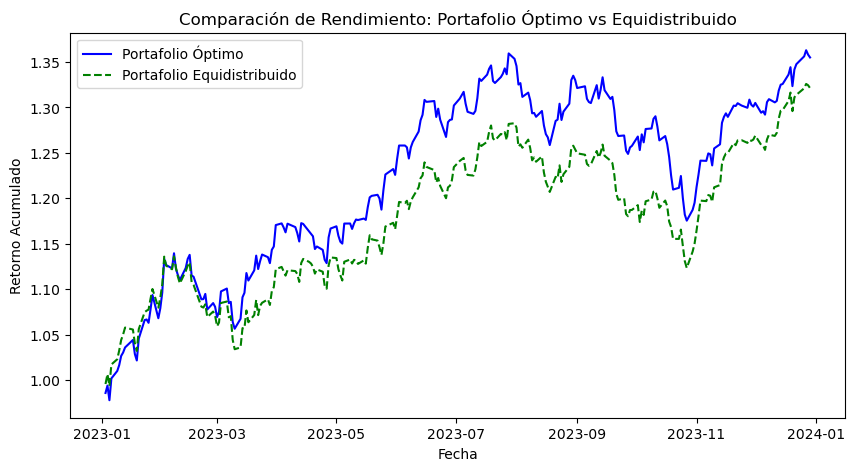

Validación de clusters y backtesting de estrategia completados.


In [8]:
# Notebook 6: Validación y Ajuste de Hiperparámetros

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

# Cargar datos
features = pd.read_csv("features_clusters.csv", index_col=0)
data = pd.read_csv("acciones_preprocesadas.csv", index_col=0, parse_dates=True)
optimal_portfolio = pd.read_csv("portafolio_optimo.csv")

# Estabilidad del clustering con diferentes valores de K
k_values = range(3, 7)
cluster_results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features.drop(columns=["Cluster", "PCA1", "PCA2"]))
    cluster_results[k] = labels

# Comparar estabilidad con Rand Score
rand_scores = []
k_prev = list(cluster_results.keys())[0]
for k in list(cluster_results.keys())[1:]:
    score = adjusted_rand_score(cluster_results[k_prev], cluster_results[k])
    rand_scores.append(score)
    k_prev = k

plt.figure(figsize=(8, 5))
plt.plot(list(k_values)[1:], rand_scores, marker='o', linestyle='--')
plt.xlabel("Número de Clusters")
plt.ylabel("Rand Score Ajustado")
plt.title("Estabilidad del Clustering con Diferentes Valores de K")
plt.show()

# Backtesting de la estrategia de inversión en el último año
returns = np.log(data / data.shift(1)).dropna()
backtest_period = returns.loc["2023-01-01":"2023-12-31"]

# Obtener pesos óptimos del portafolio y calcular su retorno
portfolio_weights = dict(zip(optimal_portfolio["Ticker"], optimal_portfolio["Peso Óptimo"]))
portfolio_returns = backtest_period.dot(pd.Series(portfolio_weights))

# Calcular rendimiento acumulado
cumulative_returns = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label="Portafolio Óptimo")
plt.title("Backtesting del Portafolio Óptimo en 2023")
plt.xlabel("Fecha")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Comparación con portafolio equidistribuido
equal_weights = np.ones(len(backtest_period.columns)) / len(backtest_period.columns)
equal_portfolio_returns = backtest_period.dot(equal_weights)
equal_cumulative_returns = (1 + equal_portfolio_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label="Portafolio Óptimo", color='blue')
plt.plot(equal_cumulative_returns, label="Portafolio Equidistribuido", color='green', linestyle='--')
plt.title("Comparación de Rendimiento: Portafolio Óptimo vs Equidistribuido")
plt.xlabel("Fecha")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

print("Validación de clusters y backtesting de estrategia completados.")
